# **Introduction** #

The video game industry is the highest earning industry, even more than the music and film industry combine. For this purpose, the video game industry has boomed with billion dollar companies and investors chasing the industry to secuer a share of lucrative market. <br/>

Unfortunately, companies often make sales units of their video games private unless their video games hit certain sales figures which are considered 'successful'. With the privacy of sales figures, it can be difficult to determine which video games have the highest ROI. However, what is publicly available are user and critic scores of video games on Meta Critic. <br/>

Traditionally higher rated products tend to outperform in sales compared to lower rated products. History has provided numerous examples where higher rated products underperformed financially to lower rated products and visa versa; however, higher rated products generally have a positive correlation with higher sells with higher consumer satisfaction. <br/>

The following data contains the top 100 highest rated games on Metacritic per year for the past 10 years. The goal is to use the highest rated games as a proxy for performance to forecast the performance of games.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
import sklearn
from prophet import Prophet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_excel('/content/drive/MyDrive/Top Video Game Sales.xlsx')

In [4]:
df

,Title,Month Released,Year Released,Genre,Secondary Genre,Single or Multiplayer,Developer,Publisher,Indie,Platform,ESRB Rating,Metacritic Critic Score,Metacritic User Score,Free-to-Play,New IP,DLC/Expansion Availability,Launch price USD,Available Microtransactions
0,Metal Gear Solid V: The Phantom Pain,September,2015,Action,Stealth,Both,Kojima Productions,Konami,No,Multiple,M,93,8.1,No,No,No,59.99,Yes
1,Bloodebourne,March,2015,Acton RPG,Not Applicable,Both,FromSoftware,Sony Computer Entertainment,No,Sony,M,92,8.9,No,Yes,No,59.99,No
2,The Witcher 3: Wild Hunt,May,2015,Action RPG,Not Applicable,Single,CD Projekt Red,CD Projekt Red,No,Multiple,M,92,9.1,No,No,No,59.99,No
3,Undertale,September,2015,RPG,Not Applicable,Single,Toby Fox,Toby Fox,Yes,PC,E10+,92,8.6,No,Yes,No,9.99,No
4,Mario Kart 8 DLC,November,2015,Racing,Kart Racing,Multiplayer,Nintendo,Nintendo,No,Nintendo,E,90,8.2,Yes,No,Yes,11.99,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,VENDETTA FOREVER,October,2024,Action,VR,Single,Meatspace Interactive,nDreams,Yes,Multiple,T,82,9.3,No,Yes,No,29.99,No
996,"Warhammer 40,000: Space Marine II",September,2024,Third-Person Shooter,Action,Single,Saber Interactive,Focus Entertainment,No,Multiple,M,82,8.0,No,No,No,59.99,Yes
997,Tiny Terry's Turbo Trip,May,2024,Adventure,Open World,Single,Snekflat,Supre Rare Originals,Yes,Multiple,E,82,7.8,No,Yes,No,17.99,No
998,Magical Delicacy,July,2024,Metroidvania,Adventure,Single,Skaule,Whitethorn Games,Yes,Multiple,E,82,5.1,No,Yes,No,14.99,No


## **Clean the Data** ##

In [5]:
#fill in any null values
df = df.fillna(pd.NA)
#drop any null values
df = df.dropna()
#multiply the user score by 10
df['Metacritic User Score'] = df['Metacritic User Score'] * 10
#change year released from integer to stirng
df['Year Released'] = df['Year Released'].astype(str)

In [6]:
#change all of the yes and nos to 1 and 0 as to make modeling easier
df.replace({'Yes': 1, 'No': 0}, inplace=True)

<ipython-input-6-1484329491>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Yes': 1, 'No': 0}, inplace=True)


In [7]:
df

,Title,Month Released,Year Released,Genre,Secondary Genre,Single or Multiplayer,Developer,Publisher,Indie,Platform,ESRB Rating,Metacritic Critic Score,Metacritic User Score,Free-to-Play,New IP,DLC/Expansion Availability,Launch price USD,Available Microtransactions
0,Metal Gear Solid V: The Phantom Pain,September,2015,Action,Stealth,Both,Kojima Productions,Konami,0,Multiple,M,93,81.0,0,0,0,59.99,1
1,Bloodebourne,March,2015,Acton RPG,Not Applicable,Both,FromSoftware,Sony Computer Entertainment,0,Sony,M,92,89.0,0,1,0,59.99,0
2,The Witcher 3: Wild Hunt,May,2015,Action RPG,Not Applicable,Single,CD Projekt Red,CD Projekt Red,0,Multiple,M,92,91.0,0,0,0,59.99,0
3,Undertale,September,2015,RPG,Not Applicable,Single,Toby Fox,Toby Fox,1,PC,E10+,92,86.0,0,1,0,9.99,0
4,Mario Kart 8 DLC,November,2015,Racing,Kart Racing,Multiplayer,Nintendo,Nintendo,0,Nintendo,E,90,82.0,1,0,1,11.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,VENDETTA FOREVER,October,2024,Action,VR,Single,Meatspace Interactive,nDreams,1,Multiple,T,82,93.0,0,1,0,29.99,0
996,"Warhammer 40,000: Space Marine II",September,2024,Third-Person Shooter,Action,Single,Saber Interactive,Focus Entertainment,0,Multiple,M,82,80.0,0,0,0,59.99,1
997,Tiny Terry's Turbo Trip,May,2024,Adventure,Open World,Single,Snekflat,Supre Rare Originals,1,Multiple,E,82,78.0,0,1,0,17.99,0
998,Magical Delicacy,July,2024,Metroidvania,Adventure,Single,Skaule,Whitethorn Games,1,Multiple,E,82,51.0,0,1,0,14.99,0


##**Exploratory Data Analysis**##

In [8]:
# Basic structure
print("Shape of dataset:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

Shape of dataset: (962, 18)

Data types:
 Title                           object
Month Released                  object
Year Released                   object
Genre                           object
Secondary Genre                 object
Single or Multiplayer           object
Developer                       object
Publisher                       object
Indie                           object
Platform                        object
ESRB Rating                     object
Metacritic Critic Score          int64
Metacritic User Score          float64
Free-to-Play                     int64
New IP                           int64
DLC/Expansion Availability       int64
Launch price USD               float64
Available Microtransactions      int64
dtype: object

Missing values:
 Title                          0
Month Released                 0
Year Released                  0
Genre                          0
Secondary Genre                0
Single or Multiplayer          0
Developer                 

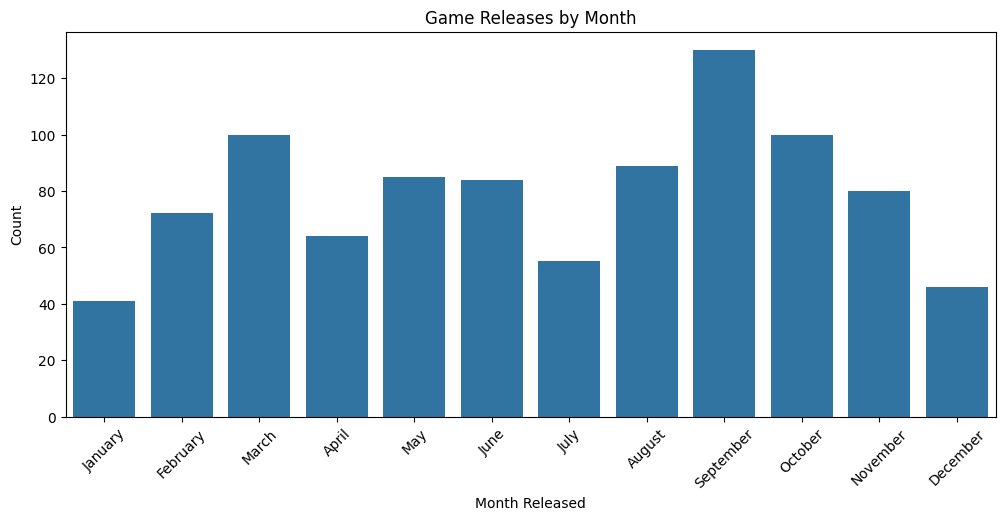

In [10]:
#Create a list of the months to plot the number of game releases by month
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
#Visualize the results
plt.figure(figsize=(12, 5))
sns.countplot(x='Month Released', data=df, order=month_order)
plt.title('Game Releases by Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

**Results show that most games come out in September**

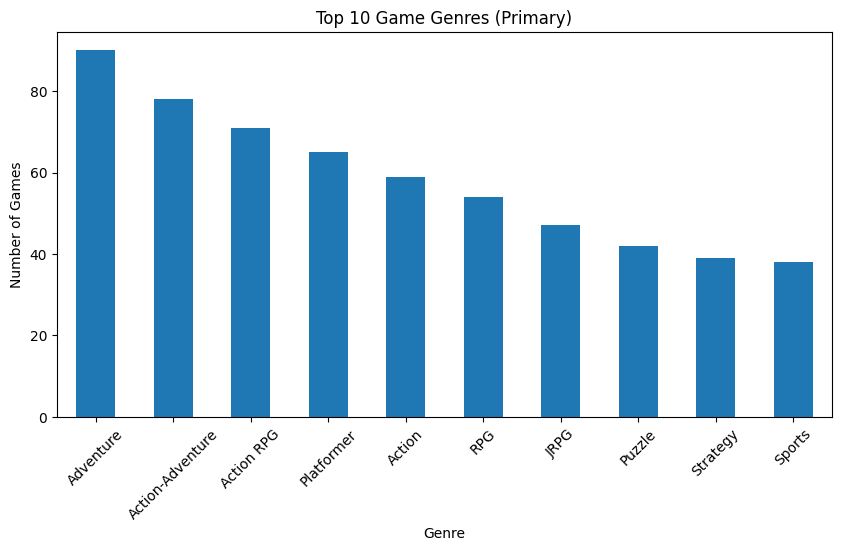

In [11]:
#View the top 10 game genres
plt.figure(figsize=(10, 5))
df['Genre'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Game Genres (Primary)')
plt.ylabel('Number of Games')
plt.xlabel('Genre')
plt.xticks(rotation=45)
plt.show()

**Results show that 'Adventure' games are the most prominent genre**

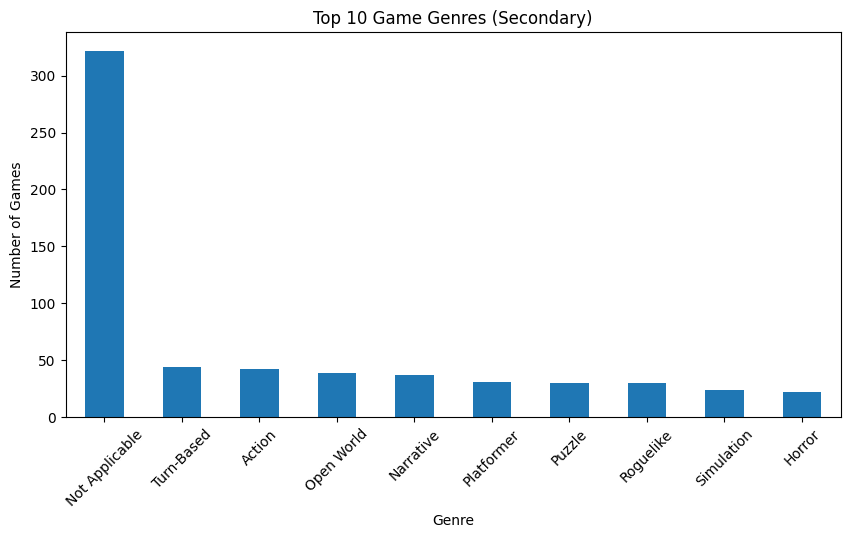

In [12]:
#Visualize the top 10 secondary genres
plt.figure(figsize=(10, 5))
df['Secondary Genre'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Game Genres (Secondary)')
plt.ylabel('Number of Games')
plt.xlabel('Genre')
plt.xticks(rotation=45)
plt.show()

**Results show that a plurality of games do not have a secondary genre**

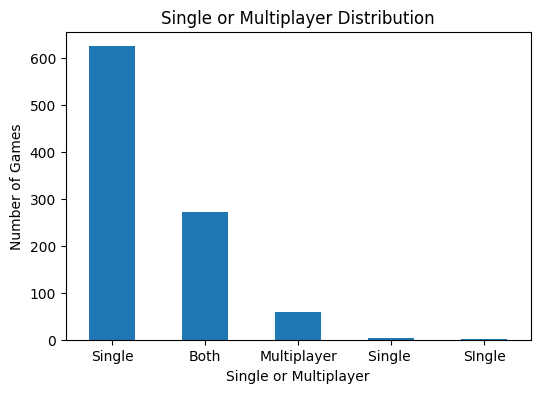

In [13]:
#Visualize the distribution of single and multiplayer games
plt.figure(figsize=(6, 4))
df['Single or Multiplayer'].value_counts().plot(kind='bar')
plt.title('Single or Multiplayer Distribution')
plt.ylabel('Number of Games')
plt.xticks(rotation=0)
plt.show()

**Most games are single player. Some of the data contains an incorrect entry for the 'single' category**

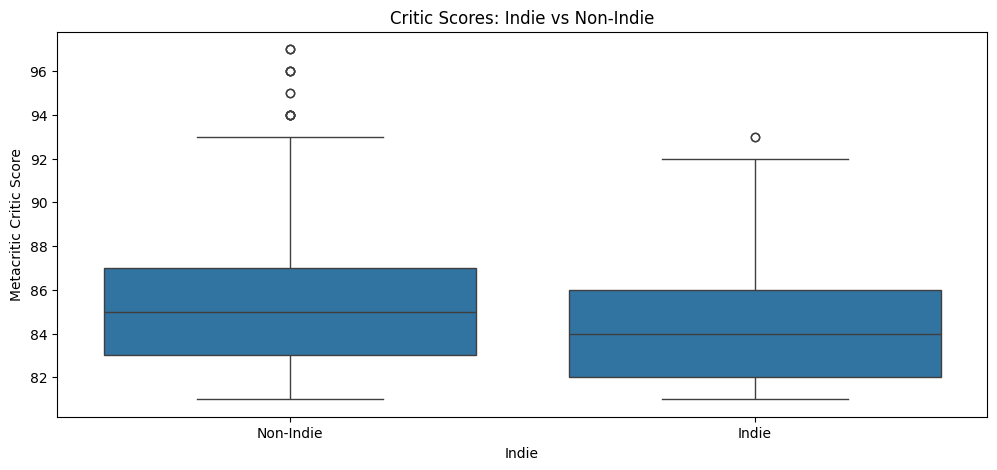

In [58]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='Indie', y='Metacritic Critic Score', data = df)
plt.title('Critic Scores: Indie vs Non-Indie')
plt.xticks([0, 1], ['Non-Indie', 'Indie'])
plt.show()

**"Non-Indie' tends to have a higher score distributions with a few outliers. 'Indie' has lower score distribitution with only one outlier.**

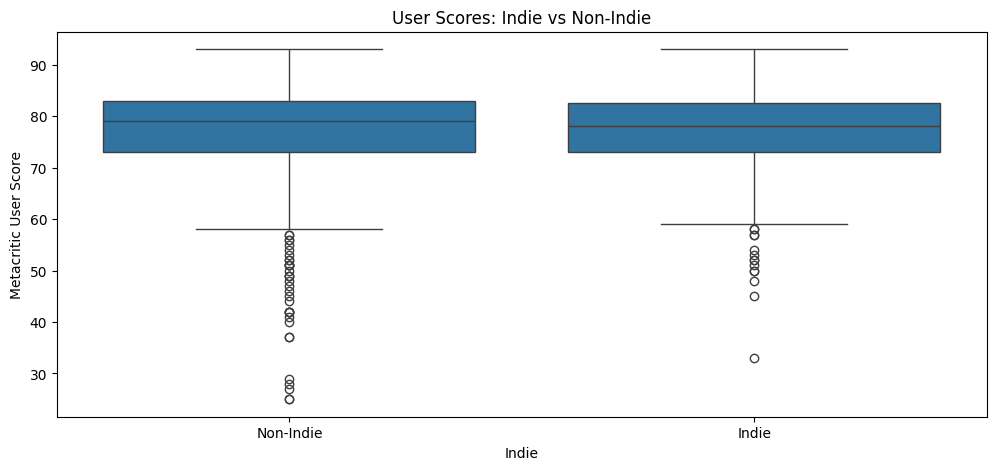

In [57]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='Indie', y='Metacritic User Score', data = df)
plt.title('User Scores: Indie vs Non-Indie')
plt.xticks([0, 1], ['Non-Indie', 'Indie'])
plt.show()

It is difficult to create conclusions for both 'Non-Indie' and 'Indie' categories, due to the numerous outliers for both graphs. More testing should be included.

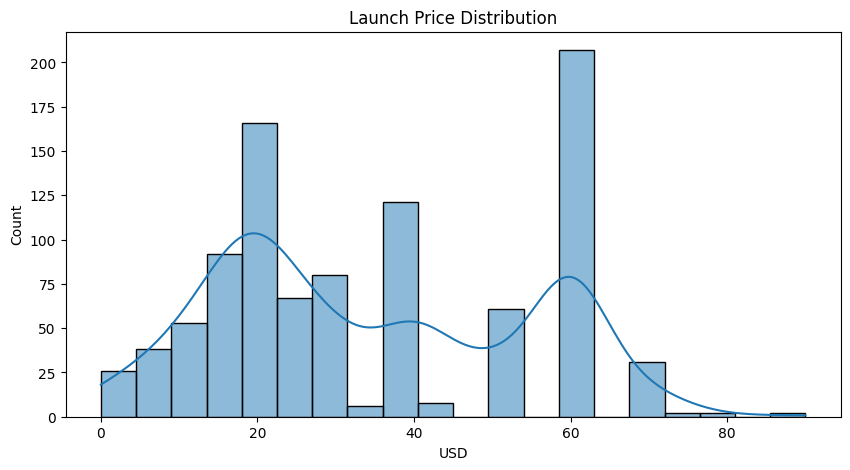

In [15]:
#Launch Price Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['Launch price USD'], bins=20, kde=True)
plt.title('Launch Price Distribution')
plt.xlabel('USD')
plt.show()

The launch price distribution is consistent with the history of video game pricing from the years listed in the dataset. Video games that were produced for lower hardware or by small publishers tend to have lower prices. Industry veterans such as Sony, Microsoft, and Nintendo usually had a base price of $60.00 during that time frame.

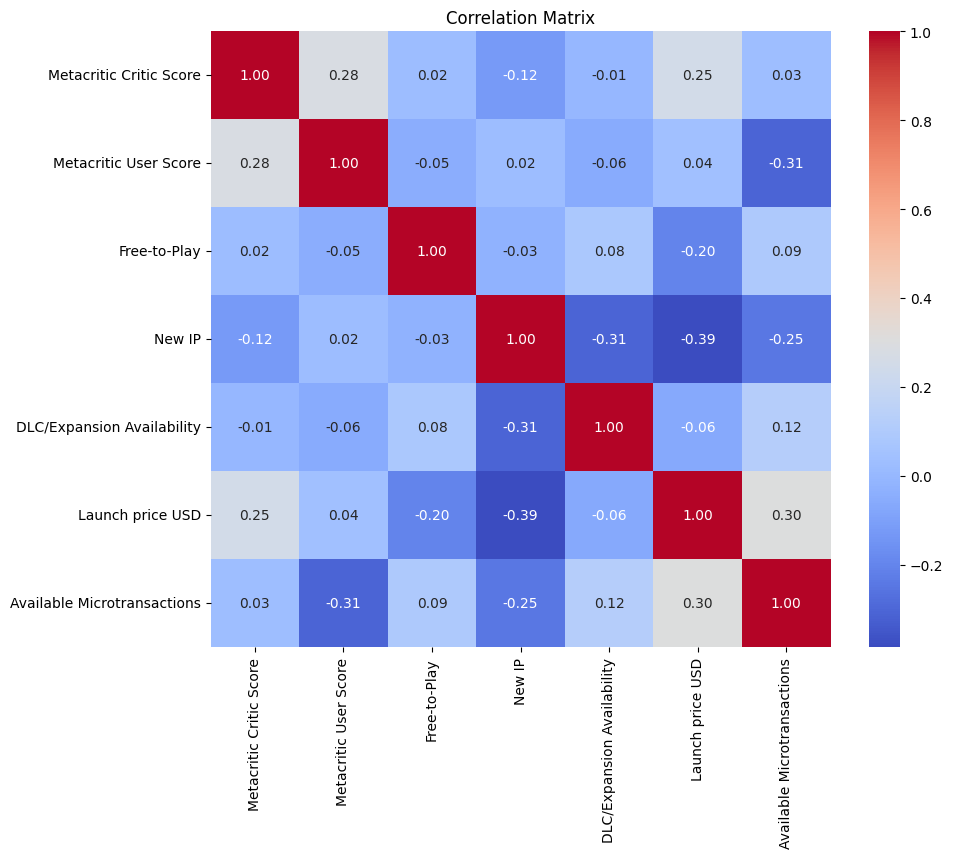

In [16]:
#Correlation Heatmap (Numeric Only)
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

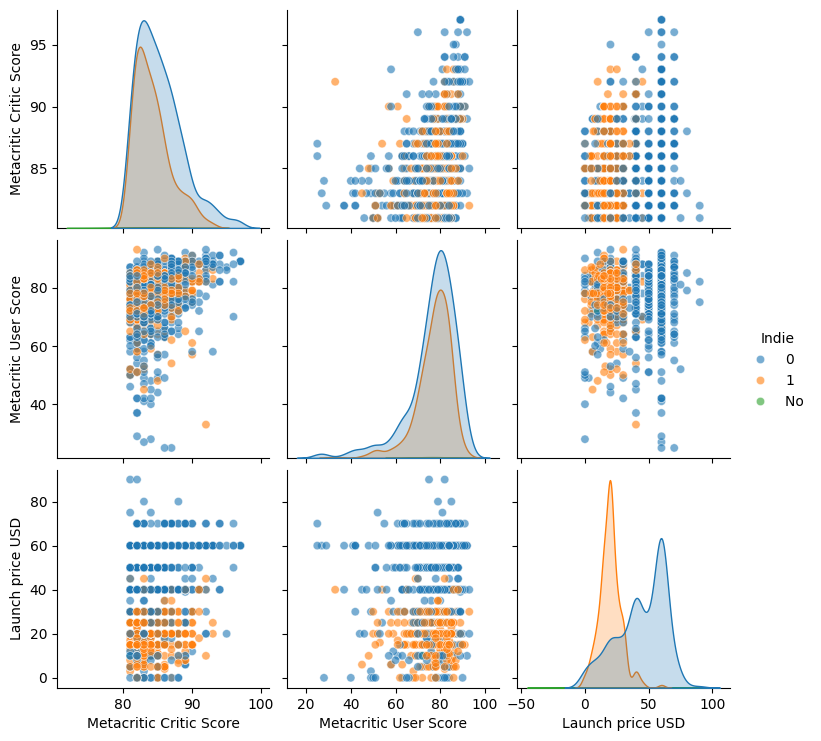

In [17]:
import seaborn as sns

sns.pairplot(df, vars=[
    'Metacritic Critic Score',
    'Metacritic User Score',
    'Launch price USD'
], hue='Indie', plot_kws={'alpha':0.6})

## **Aggregate Data Per Year** ##

In [18]:
numeric_cols = ['Metacritic Critic Score',
                'Metacritic User Score',
                'Indie',
                'Free-to-Play',
                'New IP',
                'DLC/Expansion Availability',
                'Available Microtransactions',
                'Launch price USD']

# Convert all to numeric, coercing errors to NaN
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with NaNs (again) after conversion
df = df.dropna(subset=numeric_cols)

In [19]:
# Group by year and compute market characteristics
yearly_df = df.groupby('Year Released').agg({
    'Metacritic Critic Score': 'mean',
    'Metacritic User Score': 'mean',
    'Indie': 'mean',
    'Free-to-Play': 'mean',
    'New IP': 'mean',
    'DLC/Expansion Availability': 'mean',
    'Available Microtransactions': 'mean',
    'Launch price USD': 'mean',
}).reset_index()

yearly_df.columns = ['Year', 'Avg Critic Score', 'Avg User Score', '% Indie', '% Free-to-Play',
                     '% New IP', '% DLC Availability', '% Microtransactions', 'Avg Launch Price']

# Convert year back to integer for sorting/modeling
yearly_df['Year'] = yearly_df['Year'].astype(int)

# Sort by year
yearly_df = yearly_df.sort_values('Year')

In [20]:
# Create lagged features (t-1)
for col in yearly_df.columns[1:]:
    yearly_df[f'{col} (t-1)'] = yearly_df[col].shift(1)

# Drop the first row with NaNs due to lag
yearly_df_lagged = yearly_df.dropna().reset_index(drop=True)

In [21]:
# Predict Avg Critic Score (you can pick another target too)
target = 'Avg Critic Score'
features = [col for col in yearly_df_lagged.columns if '(t-1)' in col]

X = yearly_df_lagged[features]
y = yearly_df_lagged[target]

# Train on all years except 2024
X_train = X[:-1]
y_train = y[:-1]

# Hold out 2024 for testing
X_test = X[-1:]
y_test = y[-1:]

In [22]:
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Predict for 2024
y_pred = model.predict(X_test)

# Print and compare
print(f"Actual {target} in 2024: {y_test.values[0]:.2f}")
print(f"Predicted {target} in 2024: {y_pred[0]:.2f}")

Actual Avg Critic Score in 2024: 85.89
Predicted Avg Critic Score in 2024: 84.18


In [23]:
X_2025 = X_test.copy()  # Use 2024 as lag input
y_2025_pred = model.predict(X_2025)

print(f"Forecasted {target} in 2025: {y_2025_pred[0]:.2f}")

Forecasted Avg Critic Score in 2025: 84.18


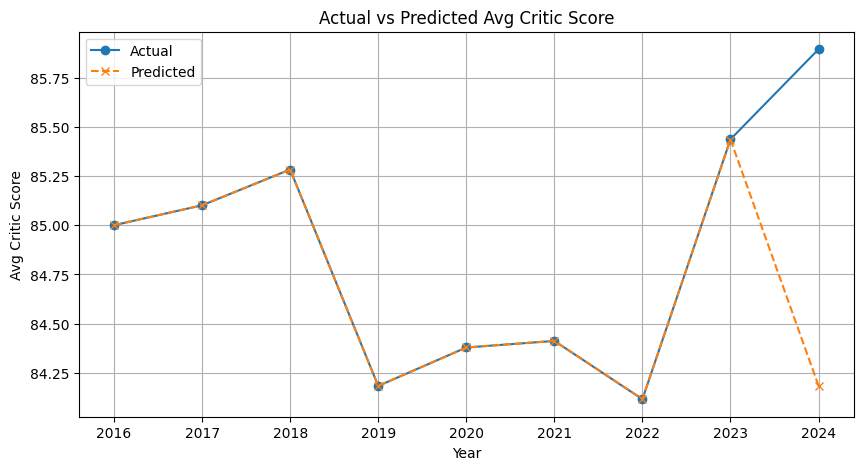

In [24]:
years = yearly_df_lagged['Year']
actual = y.values
predicted = model.predict(X)

plt.figure(figsize=(10, 5))
plt.plot(years, actual, marker='o', label='Actual')
plt.plot(years, predicted, marker='x', linestyle='--', label='Predicted')
plt.title(f'Actual vs Predicted {target}')
plt.xlabel('Year')
plt.ylabel(target)
plt.legend()
plt.grid(True)
plt.show()

###**Overfitting Problem**<br/>

As seen from the graph, there is a overfitting problem. This most likely due with a small training sample size. The next steps are to fix the overfitting.

In [25]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=20,         # fewer trees
    max_depth=2,             # shallower trees
    learning_rate=0.1,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42
)

I am simplifying the model by using fewer trees and a shallower depth.

In [26]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

tscv = TimeSeriesSplit(n_splits=3)

for train_idx, test_idx in tscv.split(X):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_test_fold)

    # Calculate RMSE inside the loop after y_test_fold and y_pred_fold are defined
    rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    print(f'RMSE for fold: {rmse:.2f}') # Added a label to clarify which fold the RMSE is for

RMSE for fold: 0.83
RMSE for fold: 0.44
RMSE for fold: 1.18


In [27]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

tscv = TimeSeriesSplit(n_splits=3)

for train_idx, test_idx in tscv.split(X):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_test_fold)

    rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))  # <- Fixed here
    print(f'RMSE: {rmse:.2f}')

RMSE: 0.83
RMSE: 0.44
RMSE: 1.18


I will now use TimeSeriesSplit to apply rolling validation for better evaluation.

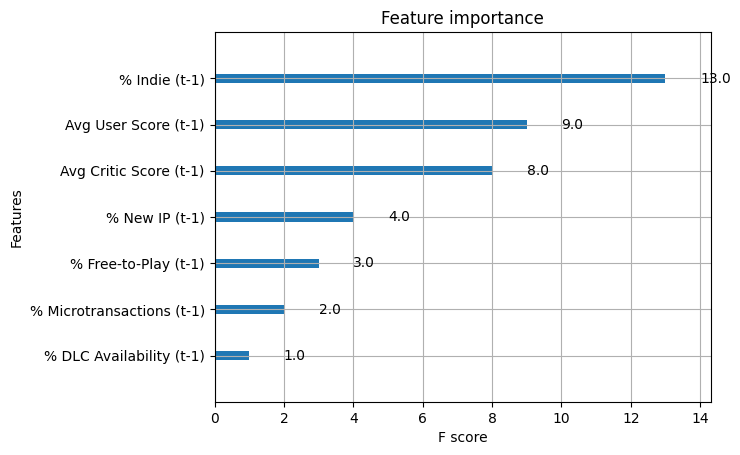

In [28]:
model.fit(X_train, y_train)
xgb.plot_importance(model)
plt.show()

I have dropped low-impact lag features.

In [29]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)
print(f"Ridge Prediction for 2024: {y_pred_ridge[0]:.2f}")

Ridge Prediction for 2024: 84.61


##Average Critic Score Forecast##

INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv80o4y48/n1t01emr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv80o4y48/kwpex0xw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10473', 'data', 'file=/tmp/tmpv80o4y48/n1t01emr.json', 'init=/tmp/tmpv80o4y48/kwpex0xw.json', 'output', 'file=/tmp/tmpv80o4y48/prophet_modeli307tzq3/prophet_model-20250611214836.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:48:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:48:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


📈 Forecasted Avg Critic Score for 2024: 86.91


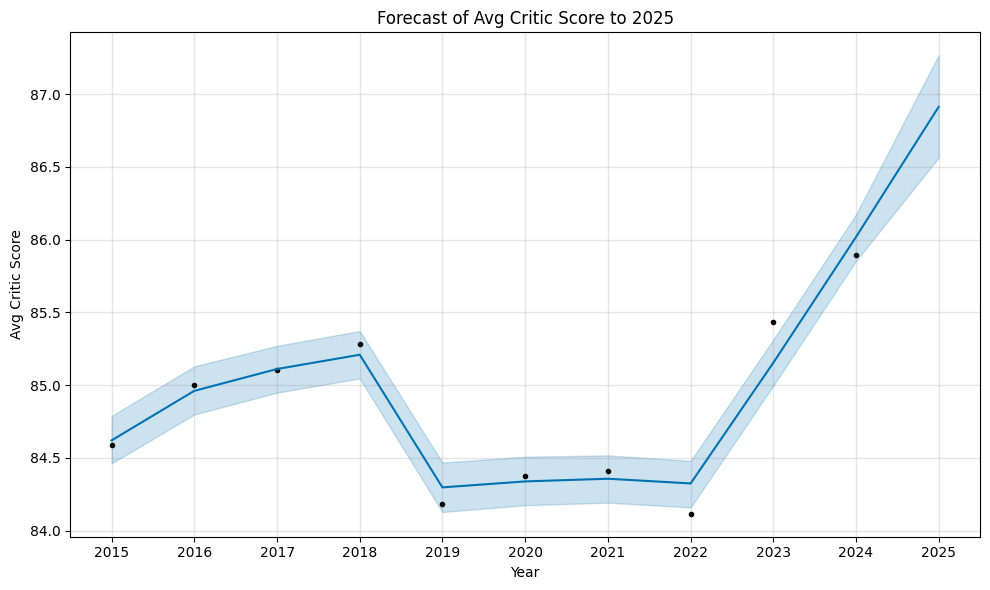

In [30]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

# Format data
prophet_df = yearly_df[['Year', 'Avg Critic Score']].copy()
prophet_df.columns = ['ds', 'y']
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')

# Initialize and train Prophet
model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
model.fit(prophet_df)

# Forecast to 2025 using 'YE' (year end) to fix deprecation warning
future = model.make_future_dataframe(periods=1, freq='Y')  # or use 'YE' if needed
forecast = model.predict(future)

# Print the last row's forecast (which should be for 2025)
forecast_last_row = forecast.iloc[-1]
forecast_2025 = forecast_last_row['yhat']
forecast_year = forecast_last_row['ds'].year

print(f"📈 Forecasted Avg Critic Score for {forecast_year}: {forecast_2025:.2f}")

# Plot forecast
fig1 = model.plot(forecast)
plt.title('Forecast of Avg Critic Score to 2025')
plt.xlabel('Year')
plt.ylabel('Avg Critic Score')
plt.grid(True)
plt.tight_layout()
plt.show()

A linear model has been used to generalize since linear models work better with limited data.

Forecasted Avg Critic Score for 2025: 85.33


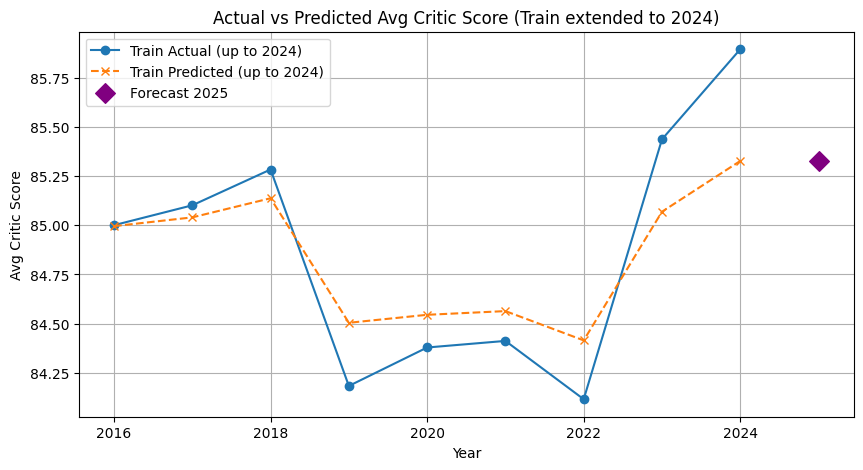

In [31]:
# Assuming yearly_df_lagged includes up to 2024, and no 2025 data yet

# Split train includes 2024, test is 2025 (which we don't have actuals for)
X_train = X  # all rows except maybe 2025 if present, but here only up to 2024
y_train = y

# --- Start: Add this block to re-initialize the XGBoost model ---
import xgboost as xgb

# Re-initialize the XGBoost model with your desired parameters
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=20,         # fewer trees
    max_depth=2,             # shallower trees
    learning_rate=0.1,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42
)
# --- End: Add this block ---


# Fit model on all data up to 2024
model.fit(X_train, y_train)

# Predict on train (including 2024)
y_train_pred = model.predict(X_train)

# Forecast 2025 using last row of X as lag input (same as before)
X_2025 = X_train.iloc[[-1]]  # last row of training features (2024 lags)
y_2025_pred = model.predict(X_2025)

print(f"Forecasted Avg Critic Score for 2025: {y_2025_pred[0]:.2f}")

# Plot with train extended to 2024
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

# Redefine years_train to include all years corresponding to X_train and y_train
years_train = yearly_df_lagged['Year'] # Now includes all 9 years

plt.plot(years_train, y_train, marker='o', label='Train Actual (up to 2024)')
plt.plot(years_train, y_train_pred, marker='x', linestyle='--', label='Train Predicted (up to 2024)')
plt.scatter([2025], y_2025_pred, color='purple', marker='D', s=100, label='Forecast 2025')
plt.title('Actual vs Predicted Avg Critic Score (Train extended to 2024)')
plt.xlabel('Year')
plt.ylabel('Avg Critic Score')
plt.legend()
plt.grid(True)
plt.show()

Overall the training and testing data were similar in their modeling. The forecasted score of 85.33 is a good estimate of the average critic score for 2025.

##Average user score forecast##

INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv80o4y48/cvf1rbdt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv80o4y48/jgk04nnj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73635', 'data', 'file=/tmp/tmpv80o4y48/cvf1rbdt.json', 'init=/tmp/tmpv80o4y48/jgk04nnj.json', 'output', 'file=/tmp/tmpv80o4y48/prophet_modelb39joyce/prophet_model-20250611214839.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:48:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:48:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


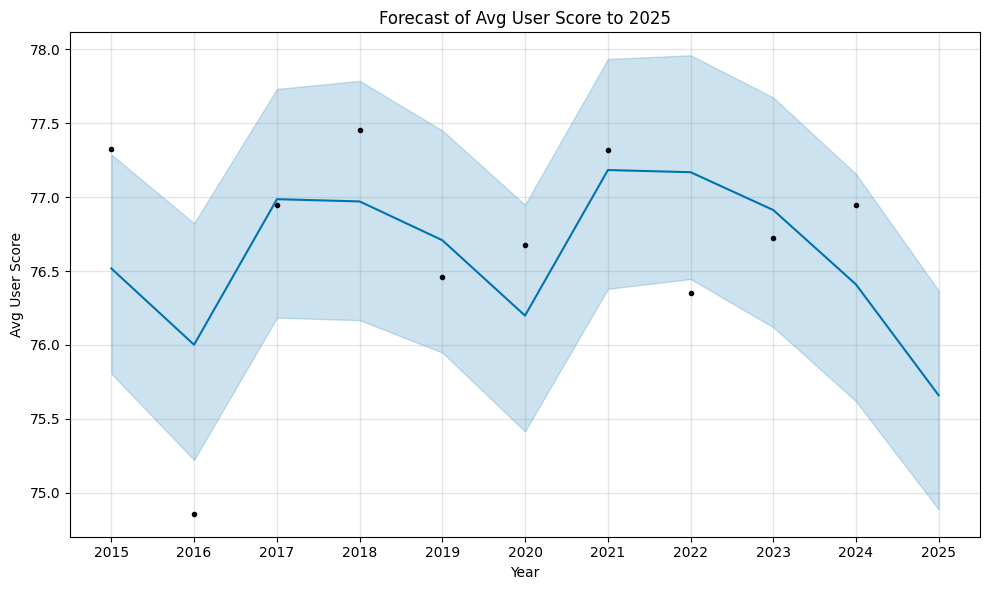

📊 Forecasted Avg User Score for 2024: 75.66


In [32]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Prepare the yearly dataframe
yearly_df = df.groupby('Year Released').agg({
    'Metacritic User Score': 'mean'
}).reset_index().rename(columns={'Metacritic User Score': 'Avg User Score'})

# Rename columns to match Prophet requirements
prophet_df = yearly_df.rename(columns={
    'Year Released': 'ds',
    'Avg User Score': 'y'
})

# Convert ds to datetime (Prophet requires this)
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')

# Step 2: Initialize and train Prophet
model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
model.fit(prophet_df)

# Step 3: Forecast to 2025
future = model.make_future_dataframe(periods=1, freq='Y')
forecast = model.predict(future)

# Step 4: Plot forecast
fig1 = model.plot(forecast)
plt.title('Forecast of Avg User Score to 2025')
plt.xlabel('Year')
plt.ylabel('Avg User Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Extract and print forecasted value for 2025
forecast_last = forecast.tail(1)
user_score_2025 = float(forecast_last['yhat'].values[0])
forecast_date_2025 = forecast_last['ds'].dt.year.values[0]

print(f"📊 Forecasted Avg User Score for {forecast_date_2025}: {user_score_2025:.2f}")

In [33]:
# Step 1: Aggregate average user score per year
yearly_df = df.groupby('Year Released').agg({
    'Metacritic User Score': 'mean'
}).reset_index().rename(columns={'Metacritic User Score': 'Avg User Score'})

# Step 2: Prepare lag feature (only 1 lag to keep more years)
yearly_df['Year'] = yearly_df['Year Released'].astype(int)
yearly_df['Lag_1'] = yearly_df['Avg User Score'].shift(1)
yearly_df_lagged = yearly_df.dropna().reset_index(drop=True)  # drops 2015 only

# Step 3: Prepare features and target
X = yearly_df_lagged[['Lag_1']]
y = yearly_df_lagged['Avg User Score']
years_train = yearly_df_lagged['Year']

# Step 4: Fit XGBoost model with anti-overfitting params
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=20,
    max_depth=2,
    learning_rate=0.1,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42
)
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

📈 Forecasted Avg User Score for 2025: 76.83


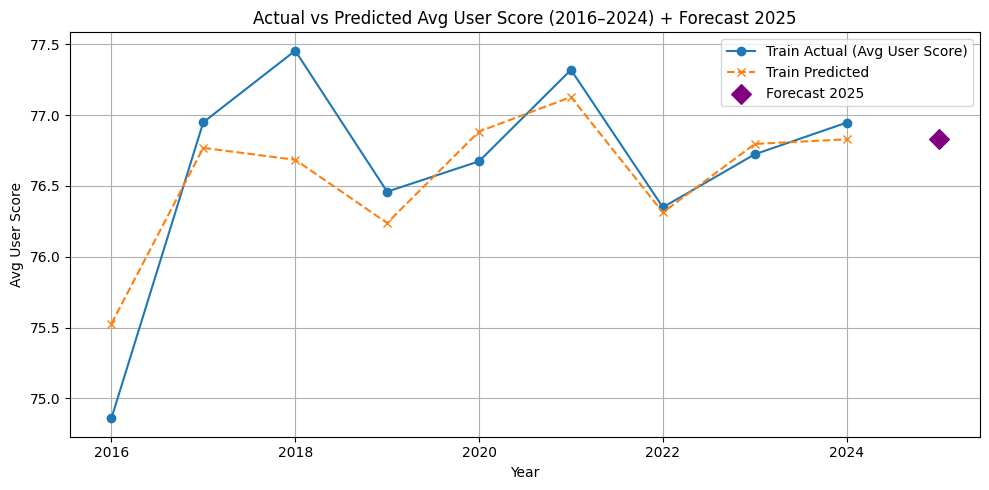

In [34]:
# Step 5: Predict on train and forecast 2025
y_train_pred = model.predict(X)
X_2025 = X.iloc[[-1]]  # last row (2024) as lag input
y_2025_pred = model.predict(X_2025)

print(f"📈 Forecasted Avg User Score for 2025: {y_2025_pred[0]:.2f}")

# Step 6: Plot
plt.figure(figsize=(10, 5))
plt.plot(years_train, y, marker='o', label='Train Actual (Avg User Score)')
plt.plot(years_train, y_train_pred, marker='x', linestyle='--', label='Train Predicted')
plt.scatter([2025], y_2025_pred, color='purple', marker='D', s=100, label='Forecast 2025')

plt.title('Actual vs Predicted Avg User Score (2016–2024) + Forecast 2025')
plt.xlabel('Year')
plt.ylabel('Avg User Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

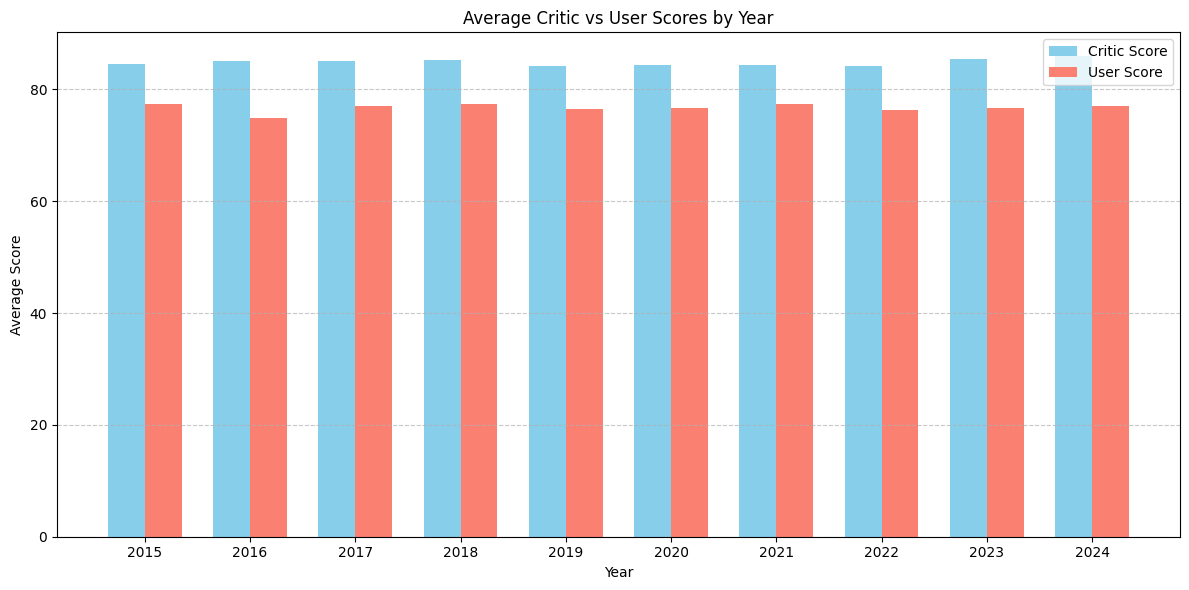

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# Group by year and calculate average scores
score_comparison = df.groupby('Year Released').agg({
    'Metacritic Critic Score': 'mean',
    'Metacritic User Score': 'mean'
}).reset_index()

# Plot bar chart
x = score_comparison['Year Released'].astype(int)
width = 0.35  # width of the bars
plt.figure(figsize=(12, 6))

plt.bar(x - width/2, score_comparison['Metacritic Critic Score'], width=width, label='Critic Score', color='skyblue')
plt.bar(x + width/2, score_comparison['Metacritic User Score'], width=width, label='User Score', color='salmon')

# Chart details
plt.xlabel('Year')
plt.ylabel('Average Score')
plt.title('Average Critic vs User Scores by Year')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Exploring Genres #

In [36]:
# Strip whitespace and convert genre to title case
df['Genre'] = df['Genre'].str.strip().str.title()

# Confirm unique genres
print(df['Genre'].unique())

['Action' 'Acton Rpg' 'Action Rpg' 'Rpg' 'Racing' 'Action-Adventure'
 'Run And Gun' "Beat 'Em Up" 'Roguelike Shooter' 'Platformer' 'Rts'
 'Puzzle' 'Rythm' 'Sports' 'Graphic Adventure' 'Interactive Movie'
 'Real-Time Strategy' 'Side-Scroll' 'Mmorpg' 'Fps' 'Moba' 'Simulation'
 "Shoot 'Em Up" 'Point-And-Click' 'Compilation' 'Tacital Rpg' 'Roguelike'
 'Digital Card Game' 'Metroidvania' 'Action-Rpg' 'Survival Horror'
 'Visual Novel' 'Pinball' 'Racing Simulation' 'Fighting'
 'Turn-Based Tactics' 'Third-Person Shooter' 'Action Shooter'
 'Dungeon Crawler' 'Art' 'Adventure' 'Tactical Rpg' 'Shooter'
 'Rhythm Shooter' 'Strategy' 'Puzzle-Platformer' 'Sports Simulation'
 'Hero Shooter' 'Farmin Simulation' 'Turn-Based Strategy' 'Jrpg'
 'Card Game' 'Construction' 'Rhythm' 'Stealth' 'Grand Strategy' 'Vr'
 'Battle Royale' 'Rouglike' 'Horror' "Shoot'Em Up" 'Survival' 'Party'
 'Acttion Rpg' "Shooter'Em Up" 'Narrative' 'Fitness' 'Flight Simulation'
 'Social Simulation' 'Game Creation' 'Action Adventure'
 

<ipython-input-36-1964618235>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Genre'] = df['Genre'].str.strip().str.title()


In [37]:
# Group by Year and Genre, then count occurrences
genre_counts = df.groupby(['Year Released', 'Genre']).size().reset_index(name='Count')

In [38]:
# Pivot to create a heatmap-ready format: Years as rows, Genres as columns
genre_matrix = genre_counts.pivot(index='Year Released', columns='Genre', values='Count').fillna(0)

# Convert index to int if it's not already
genre_matrix.index = genre_matrix.index.astype(int)

# Optional: Sort genres by total frequency over the decade
genre_matrix = genre_matrix[genre_matrix.sum().sort_values(ascending=False).index]

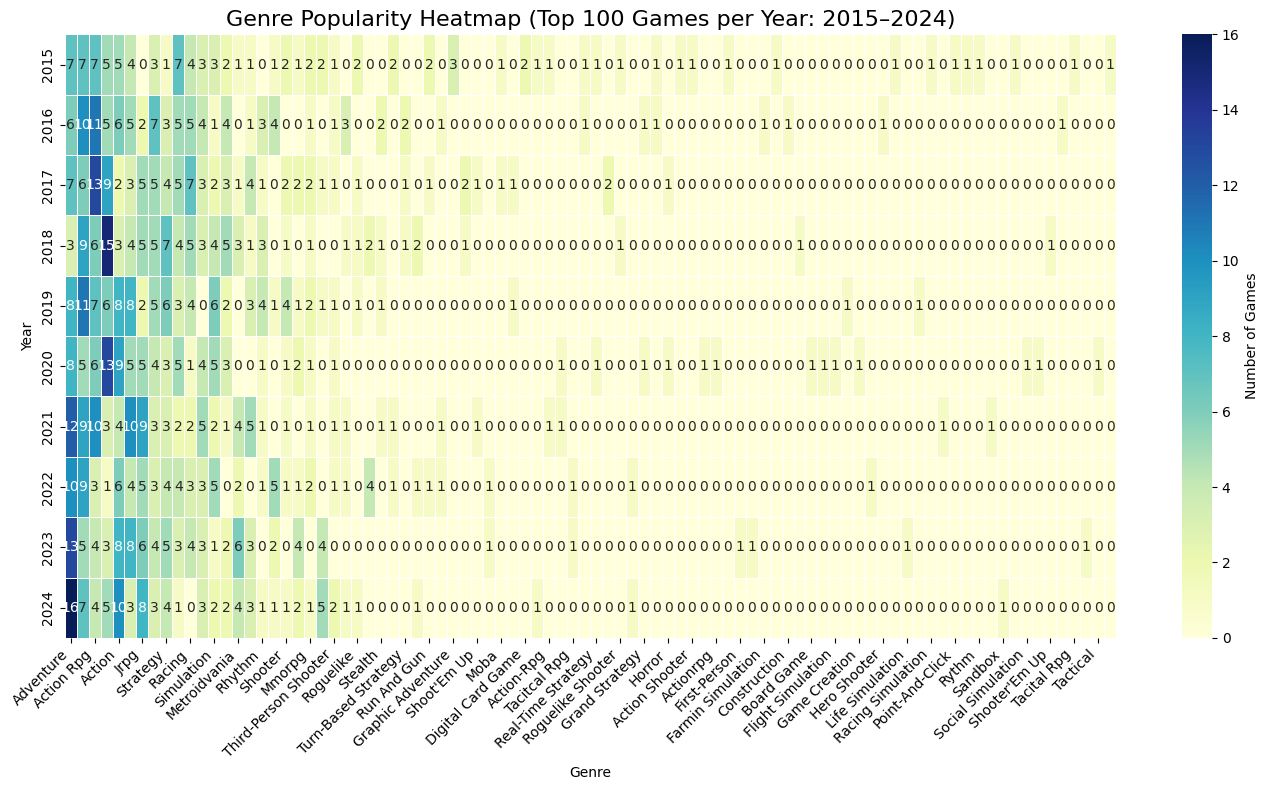

In [39]:
plt.figure(figsize=(14, 8))
sns.heatmap(genre_matrix, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=.5, cbar_kws={'label': 'Number of Games'})
plt.title('Genre Popularity Heatmap (Top 100 Games per Year: 2015–2024)', fontsize=16)
plt.xlabel('Genre')
plt.ylabel('Year')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Indie vs Non-Indie Avg Score Forecast#

In [40]:
# Make sure Year Released is int
df['Year Released'] = df['Year Released'].astype(int)

# Ensure 'Indie' is binary numeric (0 or 1)
df['Indie'] = pd.to_numeric(df['Indie'], errors='coerce')
df['Metacritic Critic Score'] = pd.to_numeric(df['Metacritic Critic Score'], errors='coerce')
df['Metacritic User Score'] = pd.to_numeric(df['Metacritic User Score'], errors='coerce')

# Drop rows with missing scores or Indie flag
df = df.dropna(subset=['Indie', 'Metacritic Critic Score', 'Metacritic User Score'])

<ipython-input-40-692967495>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year Released'] = df['Year Released'].astype(int)
<ipython-input-40-692967495>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Indie'] = pd.to_numeric(df['Indie'], errors='coerce')
<ipython-input-40-692967495>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [41]:
# Group by year and indie flag
grouped = df.groupby(['Year Released', 'Indie']).agg({
    'Metacritic Critic Score': 'mean',
    'Metacritic User Score': 'mean'
}).reset_index()

# Pivot to get separate time series for indie and non-indie games
critic_pivot = grouped.pivot(index='Year Released', columns='Indie', values='Metacritic Critic Score')
user_pivot = grouped.pivot(index='Year Released', columns='Indie', values='Metacritic User Score')

# Rename columns for clarity
critic_pivot.columns = ['Non-Indie', 'Indie']
user_pivot.columns = ['Non-Indie', 'Indie']

In [42]:
def create_lag_features(df):
    df_lagged = df.copy()
    df_lagged['Indie (t-1)'] = df['Indie'].shift(1)
    df_lagged['Non-Indie (t-1)'] = df['Non-Indie'].shift(1)
    df_lagged = df_lagged.dropna()
    return df_lagged

critic_lag = create_lag_features(critic_pivot)
user_lag = create_lag_features(user_pivot)

In [43]:
import xgboost as xgb

def train_forecast_model(df, target):
    X = df[[f'{target} (t-1)' for target in ['Indie', 'Non-Indie']]]
    y_indie = df['Indie']
    y_non_indie = df['Non-Indie']

    model_indie = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50)
    model_non_indie = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50)

    model_indie.fit(X, y_indie)
    model_non_indie.fit(X, y_non_indie)

    return model_indie, model_non_indie

critic_model_indie, critic_model_non_indie = train_forecast_model(critic_lag, 'Critic')
user_model_indie, user_model_non_indie = train_forecast_model(user_lag, 'User')

In [44]:
# Get latest known values (2024) to use as input for 2025
X_2025 = critic_lag[['Indie (t-1)', 'Non-Indie (t-1)']].iloc[-1:].copy()

# Predict 2025 critic scores
critic_indie_2025 = critic_model_indie.predict(X_2025)[0]
critic_non_indie_2025 = critic_model_non_indie.predict(X_2025)[0]

# Predict 2025 user scores
user_indie_2025 = user_model_indie.predict(X_2025)[0]
user_non_indie_2025 = user_model_non_indie.predict(X_2025)[0]

print(f"\n🎮 Forecasted 2025 Scores:\n")
print(f"Critic Score - Indie:     {critic_indie_2025:.2f}")
print(f"Critic Score - Non-Indie: {critic_non_indie_2025:.2f}")
print(f"User Score   - Indie:     {user_indie_2025:.2f}")
print(f"User Score   - Non-Indie: {user_non_indie_2025:.2f}")


🎮 Forecasted 2025 Scores:

Critic Score - Indie:     85.64
Critic Score - Non-Indie: 86.12
User Score   - Indie:     75.95
User Score   - Non-Indie: 76.11


**As seen above are the forecasted critic and user scores for 'Indie' games and 'Non-Indie' games. 'Non-Indie' games for both critics and users did better than 'Indie' games. User scores were lower than critic scores for both 'Indie' and 'Non-Indie' games.**

In [45]:
# Add the forecast to the pivot DataFrames
critic_pivot.loc[2025] = [critic_non_indie_2025, critic_indie_2025]
user_pivot.loc[2025] = [user_non_indie_2025, user_indie_2025]

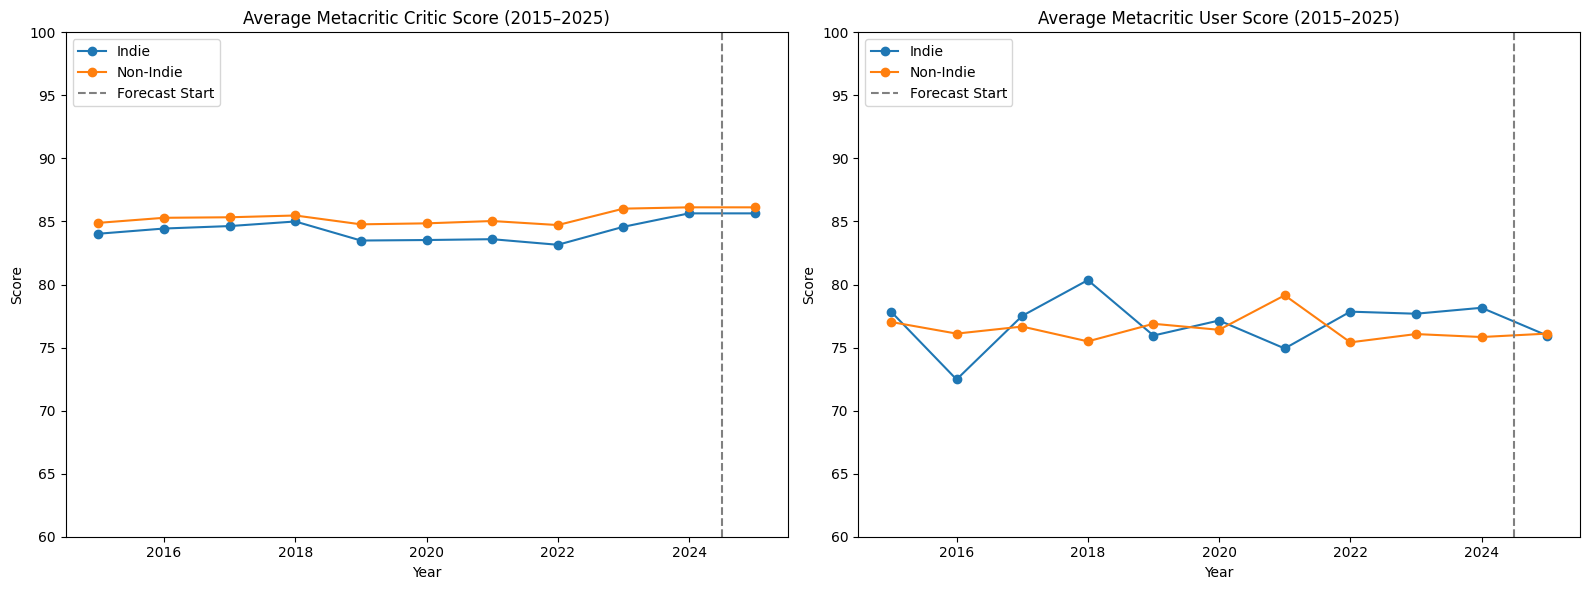

In [46]:
plt.figure(figsize=(16, 6))

# Plot critic score trends
plt.subplot(1, 2, 1)
plt.plot(critic_pivot.index, critic_pivot['Indie'], marker='o', label='Indie')
plt.plot(critic_pivot.index, critic_pivot['Non-Indie'], marker='o', label='Non-Indie')
plt.title('Average Metacritic Critic Score (2015–2025)')
plt.xlabel('Year')
plt.ylabel('Score')
plt.ylim(60, 100)
plt.axvline(2024.5, color='gray', linestyle='--', label='Forecast Start')
plt.legend()

# Plot user score trends
plt.subplot(1, 2, 2)
plt.plot(user_pivot.index, user_pivot['Indie'], marker='o', label='Indie')
plt.plot(user_pivot.index, user_pivot['Non-Indie'], marker='o', label='Non-Indie')
plt.title('Average Metacritic User Score (2015–2025)')
plt.xlabel('Year')
plt.ylabel('Score')
plt.ylim(60, 100)
plt.axvline(2024.5, color='gray', linestyle='--', label='Forecast Start')
plt.legend()

plt.tight_layout()
plt.show()

#Games Launched Month#

In [47]:
# Ensure Month Released is clean
df['Month Released'] = df['Month Released'].str.strip().str.title()

# Create datetime column for sorting (use arbitrary day)
month_map = {
    'January': 1, 'February': 2, 'March': 3,
    'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9,
    'October': 10, 'November': 11, 'December': 12
}

df['MonthNum'] = df['Month Released'].map(month_map)
df['Quarter'] = pd.to_datetime(df['MonthNum'], format='%m').dt.quarter

In [48]:
# Group by Year and Quarter
games_by_quarter = df.groupby(['Year Released', 'Quarter']).size().reset_index(name='Game Count')

# Pivot for line chart format: rows = years, cols = Q1-Q4
quarter_matrix = games_by_quarter.pivot(index='Year Released', columns='Quarter', values='Game Count').fillna(0)
quarter_matrix.columns = ['Q1', 'Q2', 'Q3', 'Q4']

In [49]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Forecast each quarter separately
forecast_2025 = {}

for q in ['Q1', 'Q2', 'Q3', 'Q4']:
    X = np.array(quarter_matrix.index).reshape(-1, 1)  # years
    y = quarter_matrix[q].values
    model = LinearRegression()
    model.fit(X, y)
    forecast = model.predict([[2025]])
    forecast_2025[q] = round(forecast[0])

In [50]:
# Append 2025 forecasts to the matrix
quarter_matrix.loc[2025] = [forecast_2025['Q1'], forecast_2025['Q2'], forecast_2025['Q3'], forecast_2025['Q4']]

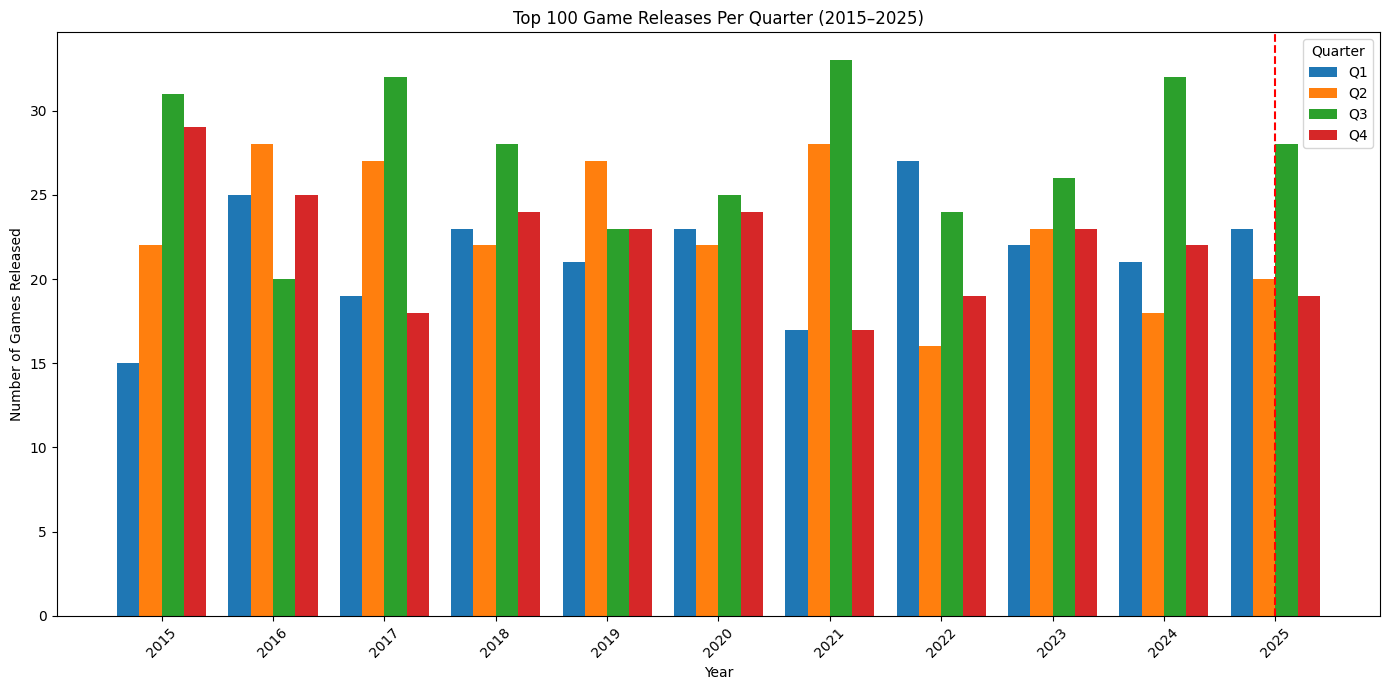

Forecasted number of games released per quarter in 2025:
Q1: 23
Q2: 20
Q3: 28
Q4: 19


In [51]:
import matplotlib.pyplot as plt
import numpy as np

years = quarter_matrix.index.astype(str)
quarters = ['Q1', 'Q2', 'Q3', 'Q4']

bar_width = 0.2
x = np.arange(len(years))

plt.figure(figsize=(14, 7))

for i, q in enumerate(quarters):
    plt.bar(x + i*bar_width, quarter_matrix[q], width=bar_width, label=q)

plt.xticks(x + 1.5*bar_width, years, rotation=45)
plt.xlabel('Year')
plt.ylabel('Number of Games Released')
plt.title('Top 100 Game Releases Per Quarter (2015–2025)')
plt.legend(title='Quarter')

# Highlight the forecasted year 2025
plt.axvline(x=len(years)-1 + bar_width*1.5, color='red', linestyle='--', label='2025 Forecast')

plt.tight_layout()
plt.show()

print("Forecasted number of games released per quarter in 2025:")
for q, val in forecast_2025.items():
    print(f"{q}: {val}")

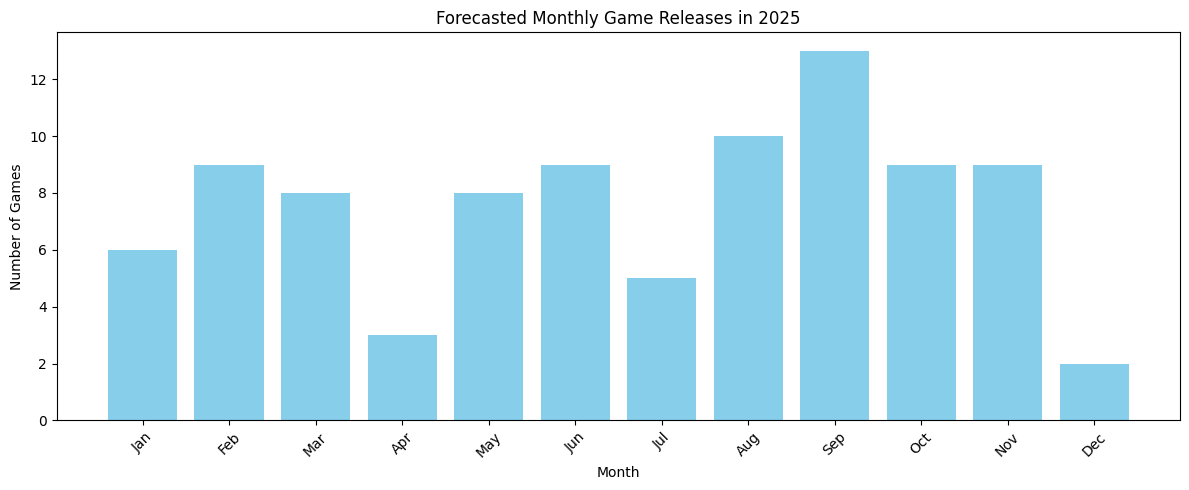

📅 Forecasted number of games released per month in 2025:
Jan: 6
Feb: 9
Mar: 8
Apr: 3
May: 8
Jun: 9
Jul: 5
Aug: 10
Sep: 13
Oct: 9
Nov: 9
Dec: 2


In [52]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Ensure Month Released is clean and mapped
df['Month Released'] = df['Month Released'].str.strip().str.title()
month_map = {
    'January': 1, 'February': 2, 'March': 3,
    'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9,
    'October': 10, 'November': 11, 'December': 12
}
df['MonthNum'] = df['Month Released'].map(month_map)

# Group by Year + Month Number
monthly_counts = df.groupby(['Year Released', 'MonthNum']).size().reset_index(name='Game Count')

# Pivot: rows = years, columns = months (1-12)
month_matrix = monthly_counts.pivot(index='Year Released', columns='MonthNum', values='Game Count').fillna(0)
month_matrix.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Forecast with Linear Regression for each month
forecast_2025_months = {}

for i, month in enumerate(month_matrix.columns, start=1):
    X = np.array(month_matrix.index).reshape(-1, 1)
    y = month_matrix[month].values
    model = LinearRegression()
    model.fit(X, y)
    forecast = model.predict([[2025]])
    forecast_2025_months[month] = round(forecast[0])

# Append forecast to month_matrix
month_matrix.loc[2025] = [forecast_2025_months[month] for month in month_matrix.columns]

# Visualize the forecasted monthly releases
plt.figure(figsize=(12, 5))
plt.bar(forecast_2025_months.keys(), forecast_2025_months.values(), color='skyblue')
plt.title('Forecasted Monthly Game Releases in 2025')
plt.ylabel('Number of Games')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print results
print("📅 Forecasted number of games released per month in 2025:")
for month, count in forecast_2025_months.items():
    print(f"{month}: {count}")

#Pricing Trends#

In [54]:
# Clean genre and convert year
df['Genre'] = df['Genre'].str.strip().str.title()
df['Year Released'] = df['Year Released'].astype(int)

# Ensure launch price is numeric
df['Launch price USD'] = pd.to_numeric(df['Launch price USD'], errors='coerce')

# Drop rows with missing genre or launch price
df = df.dropna(subset=['Genre', 'Launch price USD'])

In [55]:
# Group by year and genre, calculate average price
genre_price = df.groupby(['Year Released', 'Genre'])['Launch price USD'].mean().reset_index()

# Pivot for heatmap format
genre_price_pivot = genre_price.pivot(index='Year Released', columns='Genre', values='Launch price USD')

# Optional: Order genres by average price over the years
genre_order = genre_price_pivot.mean().sort_values(ascending=False).index
genre_price_pivot = genre_price_pivot[genre_order]

<ipython-input-56-3698380433>:11: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


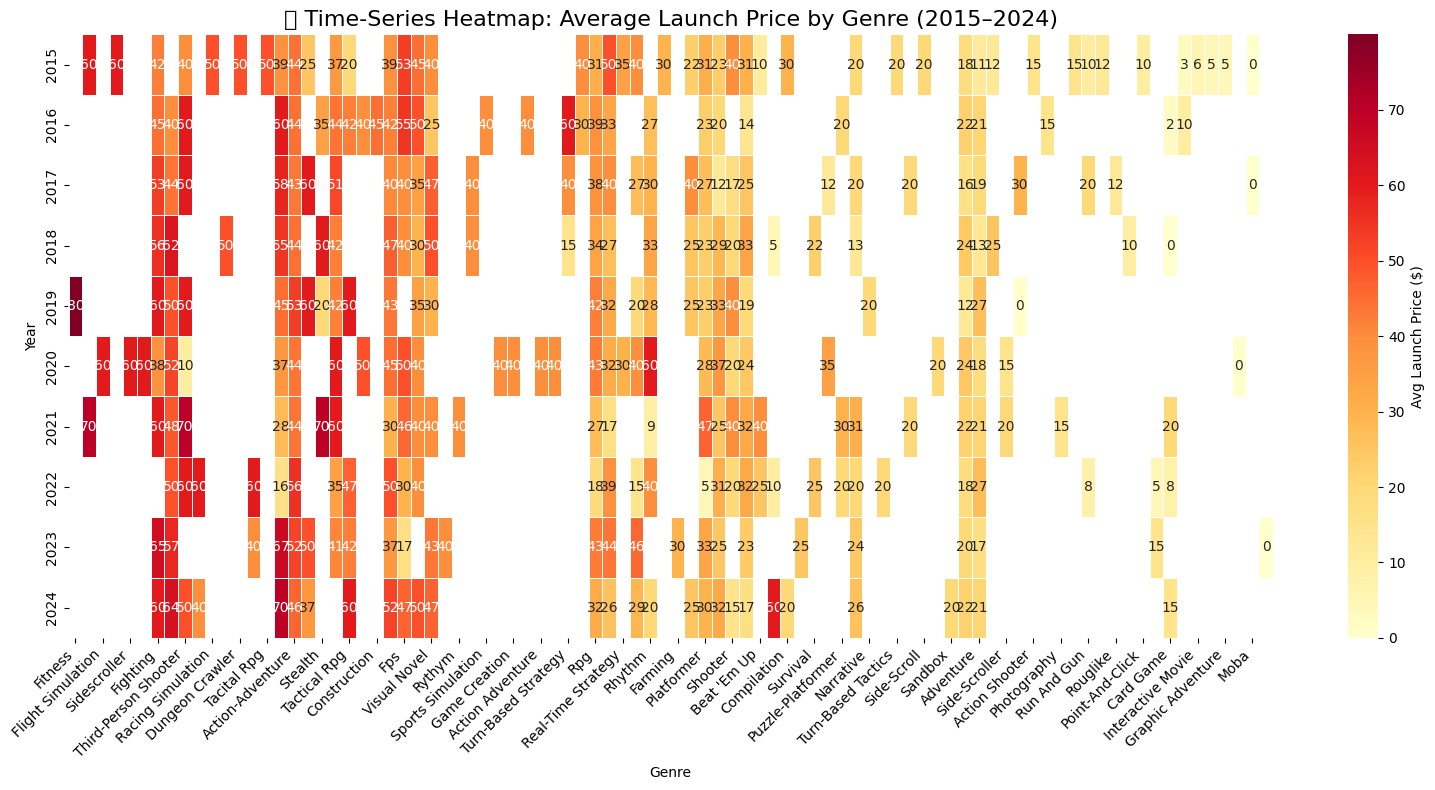

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
sns.heatmap(genre_price_pivot, annot=True, fmt=".0f", cmap="YlOrRd", linewidths=0.5, cbar_kws={"label": "Avg Launch Price ($)"})

plt.title("🎮 Time-Series Heatmap: Average Launch Price by Genre (2015–2024)", fontsize=16)
plt.xlabel("Genre")
plt.ylabel("Year")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()